In [2]:
from pathlib import Path


In [3]:
molecular_path = Path('/home/das/Downloads/Molecular')
bolus_path = Path('/home/das/Downloads/Bolus')

In [5]:
from radiomics import featureextractor

In [7]:
params = "params.yml"
extractor = featureextractor.RadiomicsFeatureExtractor(params)

In [22]:
molecular_mice = []
for mouse in molecular_path.iterdir():
    if mouse.is_dir():
        molecular_mice.append(mouse.name)

bolus_mice = []
for mouse in bolus_path.iterdir():
    if mouse.is_dir() and mouse.name in molecular_mice:
        bolus_mice.append(mouse.name)

assert set(molecular_mice) == set(bolus_mice)

mouse_names = molecular_mice

In [23]:
len(mouse_names)

11

In [25]:
import logging
import SimpleITK as sitk
import nibabel as nib
import numpy as np
from scipy.ndimage import binary_fill_holes
from tqdm import tqdm

In [39]:
molecular_scan = Path('/home/das/Downloads/Bolus/m904/m904d20150410BolusFull4D.nii')
molecular_seg = Path('/home/das/Downloads/Bolus/m904/m904d20150410BolusFull4DMasked.nii')

scan = np.asarray(nib.load(str(molecular_scan)).dataobj, dtype=np.uint8).T
seg = np.asarray(nib.load(str(molecular_seg)).dataobj, dtype=np.uint8).T

In [40]:
scan.shape, seg.shape

((146, 94, 143, 174), (146, 94, 143, 174))

In [47]:
bolus_seg = (np.max(seg, axis=3) > 0).astype(np.uint8)
bolus_seg = binary_fill_holes(bolus_seg).astype(np.uint8)
# bolus_seg = sitk.GetImageFromArray(bolus_seg)

In [177]:
bolus_image = np.asarray(nib.load(str(bolus_image_file)).dataobj, dtype=np.uint8).T

bolus_seg = np.asarray(nib.load(str(bolus_seg_file)).dataobj, dtype=np.uint8).T
# bolus_seg = (np.max(bolus_seg, axis=3) > 0).astype(np.uint8)
# bolus_seg = binary_fill_holes(bolus_seg).astype(np.uint8)

In [178]:
bolus_seg.shape, bolus_image.shape

((118, 67, 94, 175), (118, 61, 94, 175))

In [167]:
np.amax(bolus_seg[:, 30, :])

np.uint8(1)

In [ ]:
bolus_image[50, :, :, 5].shape, 

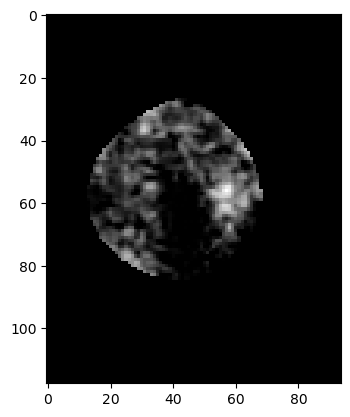

In [180]:
plt.imshow(bolus_seg[:, 30, :, 20], cmap='gray')

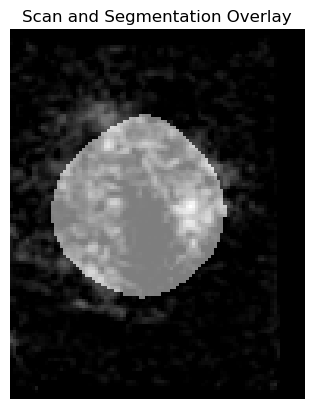

In [176]:
import matplotlib.pyplot as plt

plt.imshow(bolus_image[:, 30, :, 20], cmap='gray')
plt.imshow(bolus_seg[:, 30, :], cmap='gray', alpha=0.5)
plt.title('Scan and Segmentation Overlay')
plt.axis('off')
plt.show()

In [82]:
molecular_image.shape

(256, 414, 236, 355)

In [120]:
params = "params.yml"
extractor = featureextractor.RadiomicsFeatureExtractor(params)

In [121]:
extractor.execute(sitk.GetImageFromArray(molecular_image[:,:,:,393]), molecular_seg)

OrderedDict([('diagnostics_Versions_PyRadiomics', 'v3.0.1'),
             ('diagnostics_Versions_Numpy', '2.2.1'),
             ('diagnostics_Versions_SimpleITK', '2.4.1'),
             ('diagnostics_Versions_PyWavelet', '1.8.0'),
             ('diagnostics_Versions_Python', '3.11.5'),
             ('diagnostics_Configuration_Settings',
              {'minimumROIDimensions': 2,
               'minimumROISize': None,
               'normalize': False,
               'normalizeScale': 1,
               'removeOutliers': None,
               'resampledPixelSpacing': None,
               'interpolator': 'sitkBSpline',
               'preCrop': False,
               'padDistance': 5,
               'distances': [1],
               'force2D': False,
               'force2Ddimension': 0,
               'resegmentRange': None,
               'label': 1,
               'additionalInfo': True,
               'binWidth': 90,
               'weightingNorm': None}),
             ('diagnostics_Confi

In [125]:
m908_bolus_features = bolus_features_by_mouse.copy()
m908_molecular_features = molecular_features_by_mouse.copy()

In [146]:
m908_946_907_bolus_features = m908_bolus_features + bolus_features_by_mouse
m908_946_907_molecular_features = m908_molecular_features + molecular_features_by_mouse

In [150]:
m908_scan_names = ['20150411163832.875 KDR2.nii.gz', '20150723150109.158 kdr.nii.gz']
m908_946_907_scan_names = [m908_scan_names] + scan_names_by_mouse

In [157]:
first_10_bolus_features = m908_946_907_bolus_features + bolus_features_by_mouse
first_10_molecular_features = m908_946_907_molecular_features + molecular_features_by_mouse
first_10_scan_names = m908_946_907_scan_names + scan_names_by_mouse

In [156]:
len(scan_names_by_mouse)

7

In [128]:
len(m908_bolus_features[0])

2

In [183]:
import gc
import logging
import SimpleITK as sitk
import nibabel as nib
from scipy.ndimage import binary_fill_holes
from tqdm import tqdm

logger = logging.getLogger("radiomics.glcm")
logger.setLevel(logging.ERROR)

bolus_features_by_mouse = []
molecular_features_by_mouse = []
scan_names_by_mouse = []

for mouse in mouse_names[10:]:
    print("Mouse:", mouse)
    molecular_features = []; bolus_features = []; scan_names = []
    mouse_molecular_path = molecular_path / mouse
    for molecular_file in mouse_molecular_path.iterdir():
        if molecular_file.name.endswith('.nii.gz'):
            print("Processing file:", molecular_file.name)
            scan_names.append(molecular_file.name)
            molecular_seg_file = molecular_file.parent / "nifti_segmentation_QUANTUS" / \
                f"{molecular_file.name[:-7].replace(' ', '_')}_segmentation.nii.gz"

            molecular_image = np.asarray(nib.load(str(molecular_file)).dataobj, dtype=np.uint8).T
            molecular_seg = sitk.GetImageFromArray(
                np.asarray(nib.load(str(molecular_seg_file)).dataobj, dtype=np.uint8)
            )

            scan_features = []
            print("Starting pyradiomics for molecular...")
            for v in tqdm(range(molecular_image.shape[3])):
                cur_scan = sitk.GetImageFromArray(molecular_image[:, :, :, v])
                try:
                    scan_features.append(
                        extractor.execute(cur_scan, molecular_seg)
                    )
                except IndexError:
                    scan_features.append({})
            molecular_features.append(scan_features)
            del molecular_image, molecular_seg, cur_scan, scan_features
            gc.collect()

            scan_features = []
            bolus_image_name = f"{mouse}d{molecular_file.name[:8]}BolusFull4D.nii"
            bolus_seg_name = f"{mouse}d{molecular_file.name[:8]}BolusFull4DMasked.nii"
            bolus_image_file = bolus_path / mouse / bolus_image_name
            bolus_seg_file = bolus_path / mouse / bolus_seg_name

            assert bolus_image_file.exists(), f"Bolus scan file {bolus_image_file} does not exist."
            assert bolus_seg_file.exists(), f"Bolus segmentation file {bolus_seg_file} does not exist."
            bolus_image = np.asarray(nib.load(str(bolus_image_file)).dataobj, dtype=np.uint8).T
            bolus_seg = np.asarray(nib.load(str(bolus_seg_file)).dataobj, dtype=np.uint8).T
            bolus_seg = (np.max(bolus_seg, axis=3) > 0).astype(np.uint8)
            bolus_seg = binary_fill_holes(bolus_seg).astype(np.uint8)
            bolus_seg = bolus_seg[:, :bolus_image.shape[1], :]
            bolus_seg = sitk.GetImageFromArray(bolus_seg)

            for v in tqdm(range(bolus_image.shape[3])):
                cur_scan = sitk.GetImageFromArray(bolus_image[:, :, :, v])
                try:
                    scan_features.append(
                        extractor.execute(cur_scan, bolus_seg)
                    )
                except IndexError:
                    scan_features.append({})
            bolus_features.append(scan_features)
            del bolus_image, bolus_seg, cur_scan, scan_features
            gc.collect()

    molecular_features_by_mouse.append(molecular_features)
    bolus_features_by_mouse.append(bolus_features)
    scan_names_by_mouse.append(scan_names)

    del molecular_features, bolus_features


Mouse: m940
Processing file: 20150629185530.116 kdr.nii.gz
Starting pyradiomics for molecular...


100%|██████████| 173/173 [00:26<00:00,  6.54it/s]


Processing file: 20150630151724.806 kdr.nii.gz
Starting pyradiomics for molecular...


100%|██████████| 175/175 [00:30<00:00,  5.77it/s]


In [185]:
all_bolus_features_per_mouse = first_10_bolus_features + bolus_features_by_mouse
all_molecular_features_per_mouse = first_10_molecular_features + molecular_features_by_mouse
all_scan_names_per_mouse = first_10_scan_names + scan_names_by_mouse

In [188]:
# NOTE: m908 was computed with smaller binwidth --> goal now is to see if trends still hold overall
# Re-analysis of m908 and maybe others will likely be needed at some point

In [186]:
len(all_bolus_features_per_mouse)

11

In [189]:
import pickle
with open('molecular_features_by_mouse.pkl', 'wb') as f:
    pickle.dump(all_molecular_features_per_mouse, f)
with open('bolus_features_by_mouse.pkl', 'wb') as f:
    pickle.dump(all_bolus_features_per_mouse, f)

In [144]:
len(bolus_features_by_mouse[1][0])

169

In [206]:
mouse_names

['m908',
 'm946',
 'm907',
 'm904',
 'm947',
 'm935',
 'm939',
 'm933',
 'm948',
 'm943',
 'm940']

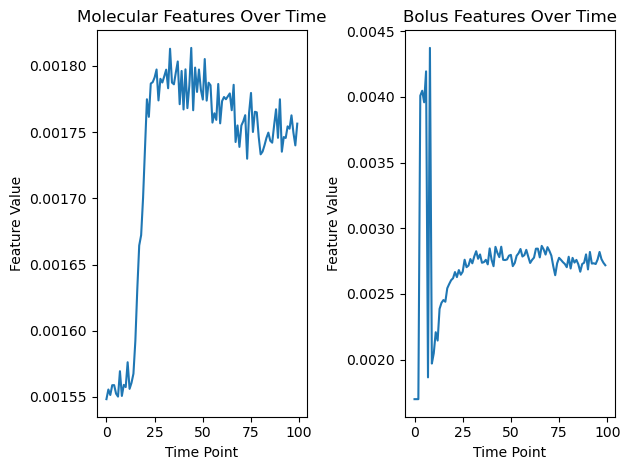

In [204]:
mouse_ix = 2; scan_ix = 0
feature_name = "original_gldm_SmallDependenceLowGrayLevelEmphasis"

bolus_ttc = []; molecular_ttc = []
for i in range(100):
    try:
        bolus_ttc.append(all_bolus_features_per_mouse[mouse_ix][scan_ix][i][feature_name])
    except KeyError:
        print("missing frame for bolus:", i)
    try:
        molecular_ttc.append(all_molecular_features_per_mouse[mouse_ix][scan_ix][i][feature_name])
    except KeyError:
        print("missing frame for molecular:", i)

fig, axs = plt.subplots(1, 2)
axs[0].plot(molecular_ttc)
axs[0].set_title('Molecular Features Over Time')
axs[0].set_xlabel('Time Point')
axs[0].set_ylabel('Feature Value')
axs[1].plot(bolus_ttc)
axs[1].set_title('Bolus Features Over Time')
axs[1].set_xlabel('Time Point')
axs[1].set_ylabel('Feature Value')
plt.tight_layout()
plt.show()